In [14]:
import numpy as np
import pandas as pd 
import os
from jarviscloud import jarviscloud
from torch import nn
import torch
from tqdm import tqdm
import albumentations as A
import cv2
import timm
import sys
import matplotlib.pyplot as plt
from torchvision import transforms
import seaborn as sns
import numpy as np
sys.path.append("../python/")

from hyperparams import Hyperparams
import model_classes as mc

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = mc.AutoEncoder('efficientnet_b0',500)
model.eval()
state_dict = torch.load('../running_models/fold_1/me_0.569_ep_10_en_efficientnet_b0_lr_5e-06_si_28.pt', map_location = device)
model.to(device)
model.load_state_dict(state_dict, strict = True)


normalise_transform = transforms.Compose([
        transforms.Normalize(mean=(33.385964741253645), std=(78.6543736268941))
        ])

In [16]:
all_images = np.load('../data/images_labels/images.npy')
all_labels = np.load('../data/images_labels/labels.npy')

In [17]:
image = torch.tensor(all_images[:5]).unsqueeze(1).to(device).float()
image = normalise_transform(image)

In [18]:
with torch.no_grad():
    output = model(image)

In [19]:
output.shape

torch.Size([5, 1, 28, 28])

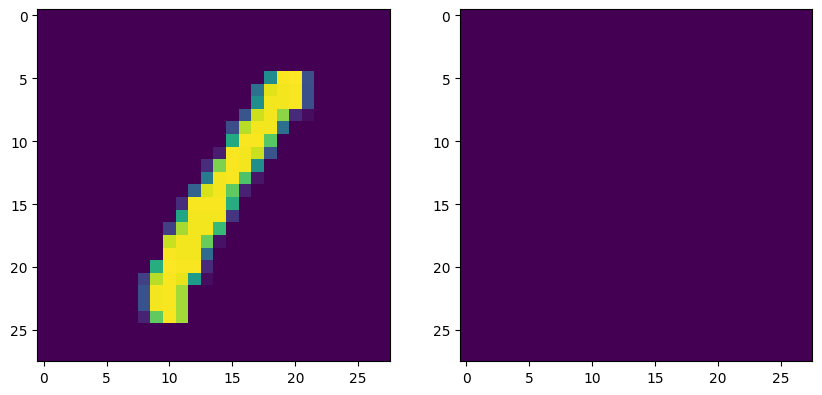

In [26]:
plt.figure(figsize = (10,5))
i = 3
plt.subplot(1,2,1)
plt.imshow(image[i].squeeze(0).cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(output[i].squeeze(0).cpu().numpy())